In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

# from scMVP.models import VAE, VAE_Peak
# from scMVP.models.multi_vae_v4 import Multi_VAE_v4
# from scMVP.models.multi_vae_v5 import Multi_VAE_v5s

import scanpy as sc
import anndata
#import seaborn as sns
# from scipy import stats
import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse



In [3]:
torch.cuda.is_available()

True

In [4]:
# Run if GPU is not available
torch.set_num_threads(40)

In [5]:
input_path = "../../appeal/share_skin/"
output_path = "../../appeal/share_skin/scMVP_output/"


share_skin_adult_dataset = {
                "gene_names": 'share_skin_scale_gene.txt',
                "gene_expression": 'share_skin_rna_normalize_count.mtx',
                "gene_barcodes": 'share_skin_cell_barcode.txt',
                "atac_names": 'bench/share_skin_scale_peak_filter200000.txt',
                "atac_expression": 'bench/share_skin_atac_normalize_count200000.mtx',
                "atac_barcodes": 'share_skin_cell_barcode.txt'
                }
#cell_embeddings = pd.read_csv(input_path+'share_skin_wnn_output.txt', sep="\t",index_col=None).iloc[:,[0,11]]
dataset = LoadData(dataset=share_skin_adult_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2021-08-03 15:39:17,289] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-08-03 15:42:23,242] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-08-03 15:42:23,733] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-03 15:42:23,735] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-03 15:42:39,695] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-08-03 15:42:39,876] INFO - scMVP.dataset.dataset | Downsampled from 29175 to 29175 cells


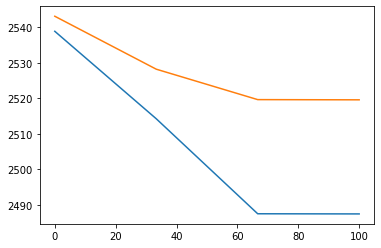

In [14]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 100, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

In [6]:
# atac dataloader
atac_dataset = GeneExpressionDataset()
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
atac_dataset.populate_from_data(
    X=dataset.atac_expression, # notice the normalization
    batch_indices=None,
    gene_names=dataset.atac_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=[],
)
rna_dataset = GeneExpressionDataset()
Ys = []
measurement = CellMeasurement(
        name="atac_expression",
        data=atac_dataset.X,
        columns_attr_name="atac_names",
        columns=atac_dataset.gene_names,
    )
Ys.append(measurement)
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
rna_dataset.populate_from_data(
    X=dataset.X,
    batch_indices=None,
    gene_names=dataset.gene_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=Ys,
)

[2021-08-03 15:43:04,722] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-03 15:43:04,725] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-08-03 15:43:04,941] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-08-03 15:43:04,943] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]


### 2. Training models

In [ ]:
# 进行预训练

# model para
n_epochs = 15
lr = 5e-3
use_batches = False
use_cuda = True
n_centroids = 15
n_alfa = 1.0

# ATAC peak embedding
pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)
is_test_pragram = False

if os.path.isfile('%s/pre_atac_trainer_200k.pkl' % output_path):
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_200k.pkl' % output_path))
    pre_atac_trainer.model.eval()
else:
    pre_atac_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_atac_trainer.model.state_dict(), '%s/pre_atac_trainer_200k.pkl' % output_path)
    pre_atac_trainer.model.eval()


In [15]:

# ATAC pretrainer_posterior:
full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
#matplotlib.use('TkAgg')
#fig, ax = plt.subplots(figsize=(7, 6))
#sc.pl.umap(prior_adata, color=["cell_type"])
#plt.show()
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()
# save data as csv file
df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=atac_dataset.barcodes )
df.insert(0,"labels",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"scvi_atac_umap_200k.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=atac_dataset.barcodes)
df.to_csv(os.path.join(output_path,"scvi_latent_atac_imputation_200k.csv"))
imputed_values = full.sequential().imputation()
df = pd.DataFrame(data=imputed_values.T, columns=atac_dataset.barcodes, index=atac_dataset.gene_names)
#df.to_csv(os.path.join(save_path,"scvi_ATAC_imputation_210324_2.csv"))


### RNA pretrain

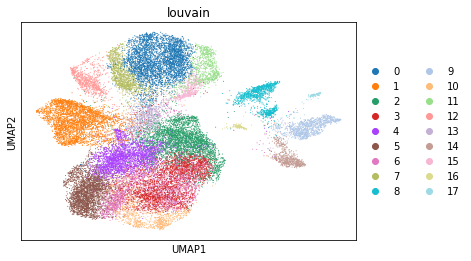

In [8]:

# RNA embedding
pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)
is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer.pkl' % output_path)

if os.path.isfile('%s/pre_trainer.pkl' % output_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))
else:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer.pkl' % output_path)
    pre_trainer.model.eval()

# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

df = pd.DataFrame(data=imputed_values.T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
#df.to_csv(os.path.join(save_path,"gene_scvi_imputation_210324_2.csv"))
# visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
#matplotlib.use('TkAgg')
#fig, ax = plt.subplots(figsize=(7, 6))
#sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)
#plt.show()
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# save data as csv file
df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=rna_dataset.barcodes )
df.insert(0,"labels",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"scvi_umap.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=rna_dataset.barcodes)
df.to_csv(os.path.join(output_path,"scvi_latent_imputation.csv"))


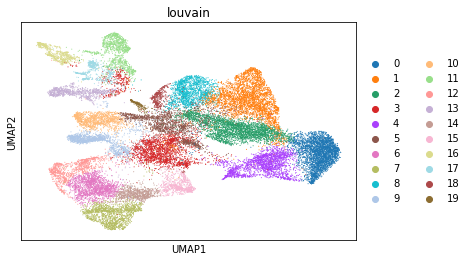

In [17]:
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()


### multivae训练

In [21]:
n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/multi_vae_softmax_200k.pkl' % output_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_softmax_200k.pkl' % output_path))
    trainer.model.eval()
else:
    pre_trainer = UnsupervisedTrainer(
        pre_vae,
        rna_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer.pkl' % output_path))

    pre_atac_trainer = UnsupervisedTrainer(
        pre_atac_vae,
        atac_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_200k.pkl' % output_path))

    n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

    # joint RNA and ATAC embedding
    trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

    trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
    for param in trainer.model.RNA_encoder.parameters():
        param.requires_grad = True
    trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
    for param in trainer.model.ATAC_encoder.parameters():
        param.requires_grad = True
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_softmax_200k.pkl' % output_path)
    trainer.model.eval()

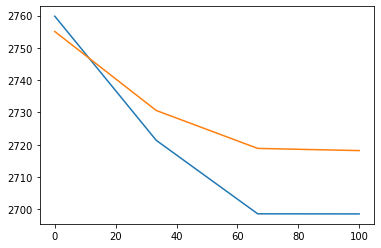

In [32]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 100, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

### 输出结果

In [ ]:
# 输出模型结果
# posterior
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
## matplotlib.use('TkAgg')
#fig, ax = plt.subplots(figsize=(7, 6))
#sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)
#plt.show()
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# save file
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=rna_dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation_200k.csv"))

df = pd.DataFrame(data=prior_adata.obsm["X_umap"],  columns=["umap_dim1","umap_dim2"] , index=rna_dataset.barcodes)
df.insert(0,"louvain",prior_adata.obs['louvain'].values)
df.to_csv(os.path.join(output_path,"multivae_umap_louvain_200k.csv"))

df = pd.DataFrame(data=imputed_values[1].T, columns=rna_dataset.barcodes, index=rna_dataset.atac_names)
#df.to_csv(os.path.join(output_path,"atac_multivae_imputation_softmax.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
#df.to_csv(os.path.join(output_path,"gene_multivae_imputation_softmax.csv"))


In [ ]:
# visulization
prior_adata = anndata.AnnData(X=latent)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
## matplotlib.use('TkAgg')
#fig, ax = plt.subplots(figsize=(7, 6))
#sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)
#plt.show()
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()